# Importing our necessary packages

In [1]:
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
plt.style.use('seaborn')

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import mean_squared_error

# Reading in and wrangling the data

In [2]:
cd = pd.read_csv("https://bitbucket.org/remcc/rob-data-sets/downloads/susedcars.csv")
cd = cd[['price','mileage','color']] #selecting our variables
cd['price'] = cd['price']/1000 #simplifying
cd['mileage'] = cd['mileage']/1000

Now let's split the used car data into **train** & **test** subsets for our linear regression models:

In [3]:
cdtr, cdte = train_test_split(cd,random_state=99, test_size=.25)

Let's double check the data to make sure everything looks good...

In [4]:
cd.head()

,price,mileage,color
0,43.995,36.858,Silver
1,44.995,46.883,Black
2,25.999,108.759,White
3,33.880,35.187,Black
4,34.895,48.153,Black


In [5]:
print('Train subset dimensions',cdtr.shape)
print('Test subset dimensions',cdte.shape)

Train subset dimensions (750, 3)
Test subset dimensions (250, 3)


Text(0, 0.5, 'price')

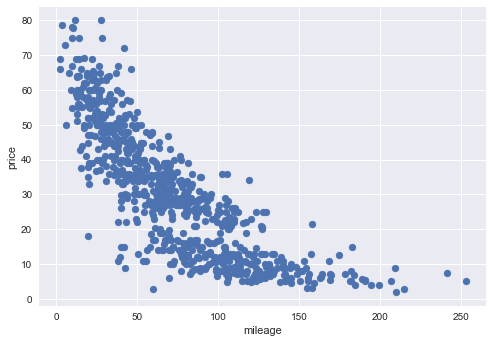

In [6]:
plt.scatter(cdtr['mileage'],cdtr['price'])
plt.xlabel('mileage'); plt.ylabel('price')

Our data is formatted correctly and the model subsets are ready, let's move on to...

# Model 1: Linear regression of log('price') on 'mileage' and 'color'

Let's create *dummy variables* for 'color' using *one hot encoding*:

In [7]:
one_hot = LabelBinarizer()
cdumtr = one_hot.fit_transform(cdtr['color'])
cdumte = one_hot.fit_transform(cdte['color'])

Next, we'll create new train and test Numpy arrays such that the first column includes mileage while the last four encode a color:

In [8]:
Xctr = np.hstack([cdtr.iloc[:,[1]].to_numpy(),cdumtr[:,1:4]])
Xcte = np.hstack([cdte.iloc[:,[1]].to_numpy(),cdumte[:,1:4]])

In [9]:
Xctr

array([[ 47.894,   0.   ,   0.   ,   0.   ],
       [ 27.295,   0.   ,   0.   ,   0.   ],
       [131.121,   0.   ,   0.   ,   1.   ],
       ...,
       [151.939,   1.   ,   0.   ,   0.   ],
       [ 80.645,   0.   ,   0.   ,   1.   ],
       [104.118,   0.   ,   1.   ,   0.   ]])

Instead of using 'price' as our Y, let's use the log of price:

In [10]:
logprice = np.log(cdtr['price'])

Finally, we're ready for the regression model:

In [11]:
model1 = LinearRegression(fit_intercept=(True))
model1.fit(Xctr, logprice) #mileage + dummy colors vs. log of price

LinearRegression()

Let's see how accurate our model is:

Text(0, 0.5, 'log(Price) predictions using mileage and color')

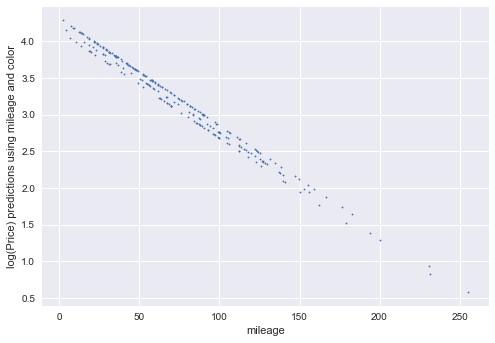

In [12]:
logpriceTest = model1.predict(Xcte)
plt.scatter(cdte['mileage'],logpriceTest,s=2.0)
plt.xlabel('mileage'); plt.ylabel('log(Price) predictions using mileage and color')

Text(0, 0.5, 'log(Price)')

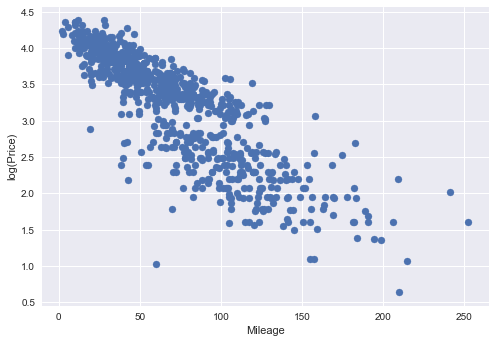

In [13]:
plt.scatter(cdtr['mileage'],logprice)
plt.xlabel('Mileage'); plt.ylabel('log(Price)')

We can also check our RMSE:

In [14]:
def rmse(y,yh):
    return(math.sqrt(np.mean((y-yh)**2)))
print('Root mean squared error:', rmse(logpriceTest, cdte['price']))

Root mean squared error: 33.79983671131382


Yikes, not the best RMSE - we'll see how it holds up vs. Model 2.
Let's exponentiate our results as well:

Text(0, 0.5, 'Exponentiated Predicted Price')

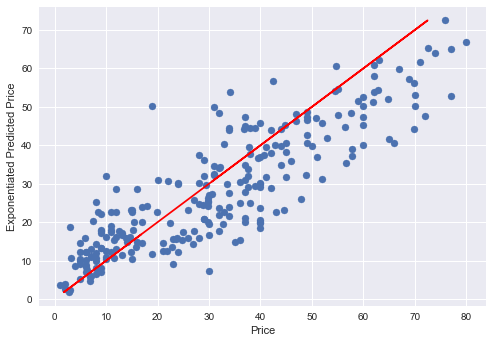

In [15]:
expPrice = np.exp(logpriceTest)
plt.scatter(cdte['price'],expPrice)
plt.plot(expPrice,expPrice, c='red')
plt.xlabel('Price');plt.ylabel('Exponentiated Predicted Price')

# Model 2: Linear regression of 'price' on 'mileage,' 'mileage squared' & 'color' 

Let's create all new data frames for this second model:

In [16]:
cd2 = pd.read_csv("https://bitbucket.org/remcc/rob-data-sets/downloads/susedcars.csv")
cd2 = cd2[['price','mileage','color']] #selecting our variables
cd2['price'] = cd2['price']/1000 #simplifying
cd2['mileage'] = cd2['mileage']/1000

We also need to create a data frame for 'mileage squared:'

In [17]:
mileagesq = cd2['mileage'].apply(lambda x: math.pow(x, 2))
cd2['mileagesq'] = mileagesq
cd2 = cd2[['price', 'mileage', 'mileagesq', 'color']]
cd2['mileagesq'].head

<bound method NDFrame.head of 0       1358.512164
1       2198.015689
2      11828.520081
3       1238.124969
4       2318.711409
           ...     
995     8026.188921
996       30.935844
997     3808.864656
998     1617.567961
999    17192.716641
Name: mileagesq, Length: 1000, dtype: float64>

Now let's build our second model. First we'll do one hot encoding again:

In [18]:
cd2tr, cd2te = train_test_split(cd2,random_state=99, test_size=.25)
one_hot2 = LabelBinarizer()
cd2umtr = one_hot2.fit_transform(cd2tr['color'])
cd2umte = one_hot2.fit_transform(cd2te['color'])
X2ctr = np.hstack([cd2tr.iloc[:,1:3].to_numpy(),cd2umtr[:,1:4]])
X2cte = np.hstack([cd2te.iloc[:,1:3].to_numpy(),cd2umte[:,1:4]])

Then we'll make our second regression model!

In [19]:
model2 = LinearRegression(fit_intercept=(True))
model2.fit(X2ctr, cd2tr['price'])
priceTest2 = model2.predict(X2cte)

Plots

Text(0, 0.5, 'Predictions using mileage, mileage squared and color')

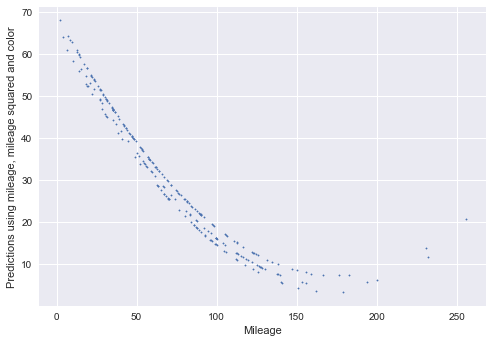

In [20]:
plt.scatter(cd2te['mileage'],priceTest2,s=2.0)
plt.xlabel('Mileage'); plt.ylabel('Predictions using mileage, mileage squared and color')

Text(0, 0.5, 'Predicted Price')

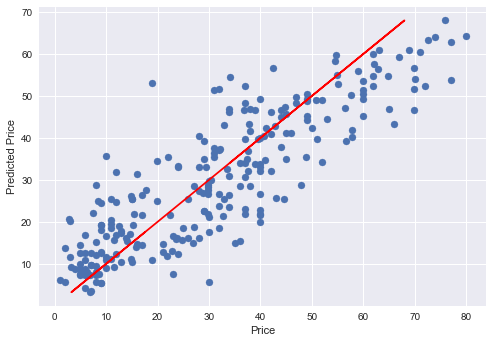

In [21]:
plt.scatter(cdte['price'],priceTest2)
plt.plot(priceTest2,priceTest2, c='red')
plt.xlabel('Price');plt.ylabel('Predicted Price')

In [22]:
print('Root mean squared error:', rmse(priceTest2, cd2te['price']))

Root mean squared error: 9.97094716570109
